In [6]:
from src.preprocessing import 

'src.preprocessing'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import utils

%load_ext autoreload
%autoreload 2

# Read Data

# Read Data

In [256]:

config = utils.get_config('config/config.ini')
raw_load_data_path = utils.get_full_path(config['data_paths']['raw_load_data'])
raw_temp_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])

raw_load_data = pd.read_csv(raw_load_data_path, parse_dates=[0])
raw_temp_data = pd.read_csv(raw_temp_data_path, parse_dates=[0])

print(raw_load_data.head())
print(raw_temp_data.head())

        Date  Hour     Load
0 2005-01-01     1  156.545
1 2005-01-01     2  147.924
2 2005-01-01     3  141.037
3 2005-01-01     4  139.125
4 2005-01-01     5  140.482
        Date  Hour  Station ID  Temperature
0 2005-01-01     1           1           43
1 2005-01-01     2           1           41
2 2005-01-01     3           1           40
3 2005-01-01     4           1           39
4 2005-01-01     5           1           38


## preliminary preprocessing

In [257]:
raw_load_data.columns = ['date', 'hr', 'load']
raw_temp_data.columns = ['date', 'hr', 'station_id', 'temperature']



raw_load_data['datetime'] = raw_load_data.date + pd.to_timedelta(raw_load_data.hr, unit='h')

# Exploration

## knowledge from the data
Based on intuition, we could explore various trajectories which might be relevant to electriity demand. This may include factors based on time of the day, day of the week and month of the year. However, another way might be to leverage the power of unsupervised techniques in discerning patterns from the data with limited assumptions.

In particular, we would use the PCA in order to decompose the daily electricity usage patterns. To do this, the data would be transformed such that each 24 hour day is treated as a sample. The PCA might then be able to extract daily usage modes through its first few principal components

<Axes: xlabel='datetime'>

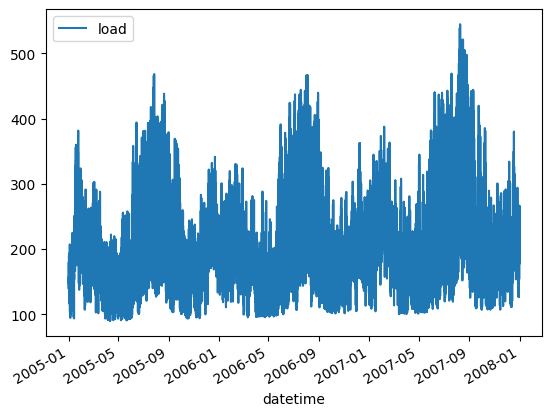

In [239]:

raw_load_data.plot(x='datetime', y='load')

/tmp/ipykernel_26600/688738188.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  raw_load_data.set_index('datetime').resample(v)['load'].sum().plot(ax=ax)


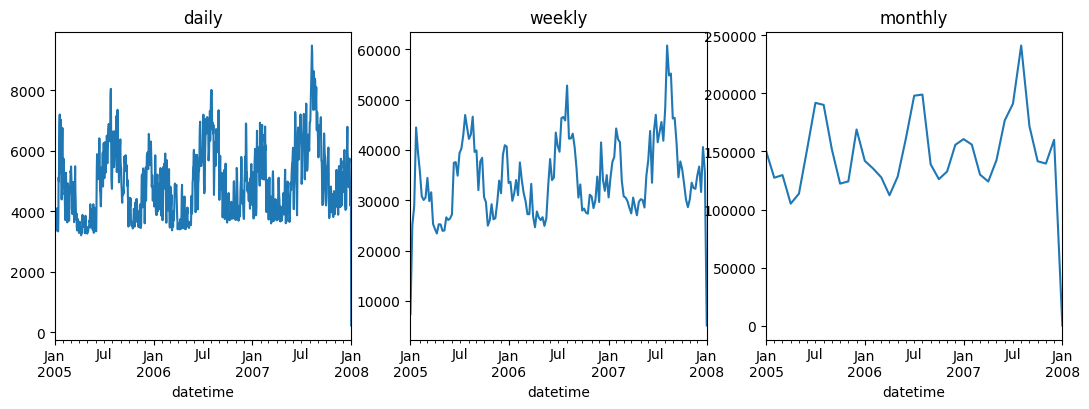

In [290]:
resample_dict = {'daily':'D', 'weekly':'W', 'monthly':'M'}

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs = axs.flatten()
for i, (k, v) in enumerate(resample_dict.items()):

    ax = axs[i]

    raw_load_data.set_index('datetime').resample(v)['load'].sum().plot(ax=ax)
    ax.set_title(k)

Note: daylight saving causes multiple hour 2 on one day and no hour 2 on another day within a year

In [153]:
pivoted_load_data = raw_load_data.pivot_table(values='load', index='date', columns='hr')

from sklearn.decomposition import PCA
X = pivoted_load_data.loc[:, 3:].values  # from 3 because some hours are null for hour 2


pca = PCA().fit(X)
ftv = pca.explained_variance_[0:] / np.sum(pca.explained_variance_[0:])

X_pca = pca.transform(X)
X_mean = np.mean(X, axis=0)

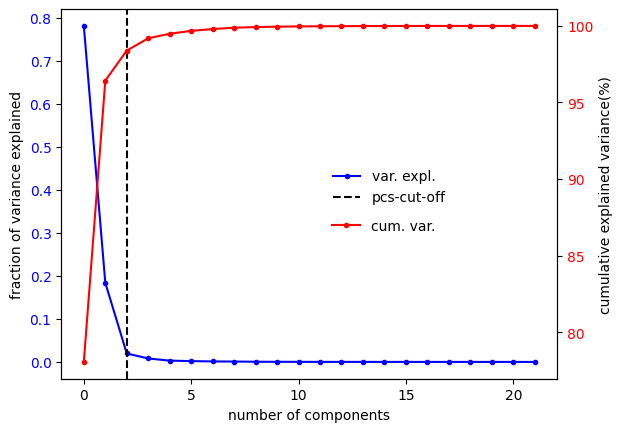

In [144]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax2.plot(np.cumsum(pca.explained_variance_ratio_*100.0), '-.', c='r',  label='cum. var.')
ax2.plot(np.cumsum(ftv*100.0), '.-', c='r',  label='cum. var.')
ax.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance(%)');
ax2.ticklabel_format(useOffset=False)


ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax.plot(np.arange(X.shape[1])[0:], pca.explained_variance_ratio_[0:], '.-', c='b', label='var. expl.')

ax.set_ylabel('fraction of variance explained')

ax.axvline(x=2,  ls='--', c='black', label='pcs-cut-off')

ax.legend(bbox_to_anchor=(0.8,0.6), frameon=False)
ax2.legend(bbox_to_anchor=(0.78,0.465), frameon=False)
ax.grid(False)
ax2.grid(False)

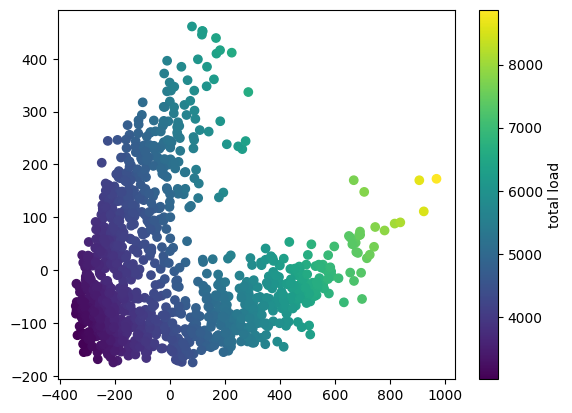

In [149]:
X_pca = PCA(2).fit_transform(X)

total_load = X.sum(axis=1)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=total_load, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='total load')


/tmp/ipykernel_26600/2717544604.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_label, cmap=plt.cm.get_cmap('jet', 2));


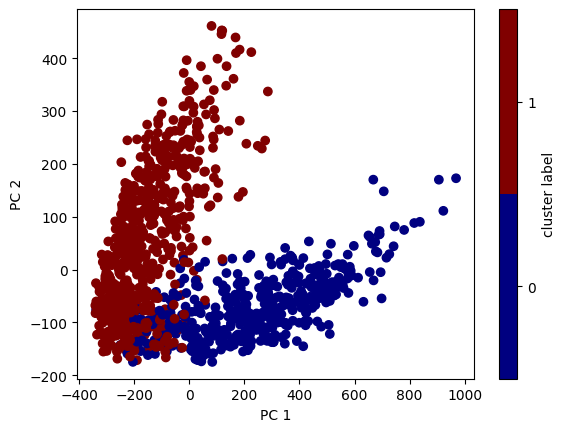

In [244]:
from sklearn.mixture import GaussianMixture as GM

gmm = GM(n_components=3, covariance_type='full', random_state=0)

gmm.fit(X_pca)
cluster_label = gmm.predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_label, cmap=plt.cm.get_cmap('jet', 2));
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(ticks=range(2), label='cluster label')
plt.clim(-0.5, 1.5);


        date  hr     load            datetime  cluster
0 2005-01-01   1  156.545 2005-01-01 01:00:00        1
1 2005-01-01   2  147.924 2005-01-01 02:00:00        1
2 2005-01-01   3  141.037 2005-01-01 03:00:00        1
3 2005-01-01   4  139.125 2005-01-01 04:00:00        1
4 2005-01-01   5  140.482 2005-01-01 05:00:00        1
                                          date    hr        load  \
cluster datetime                                                   
0       00:00:00 2006-07-19 14:55:21.033210368  24.0  198.172469   
        01:00:00 2006-07-19 14:55:21.033210368   1.0  166.980349   
        02:00:00 2006-07-19 19:44:28.391867136   2.0  149.014741   
        03:00:00 2006-07-19 14:55:21.033210368   3.0  138.312419   
        04:00:00 2006-07-19 14:55:21.033210368   4.0  132.160072   

                                      datetime  
cluster datetime                                
0       00:00:00 2006-07-20 14:55:21.033210112  
        01:00:00 2006-07-19 15:55:21.033210368

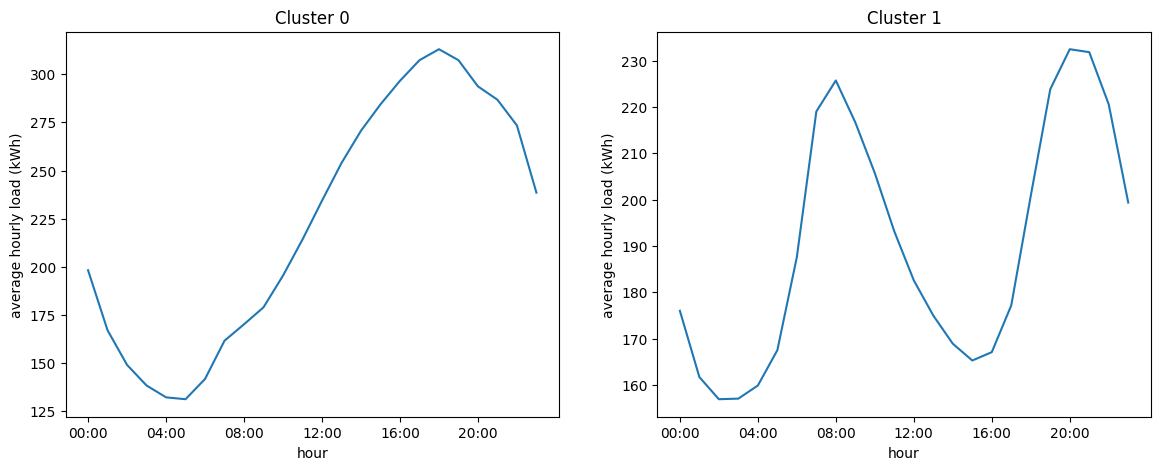

In [238]:
pivoted_load_data['cluster'] = cluster_label

temp_df = raw_load_data.join(pivoted_load_data['cluster'], on='date')
print(temp_df.head())
temp_df = temp_df.groupby(['cluster', temp_df.datetime.dt.time]).mean()
print(temp_df.head())
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    temp_df.loc[i]['load'].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title(f'Cluster {i}')
    ax[i].set_ylabel('average hourly load (kWh)')
    ax[i].set_xlabel('hour')

In [192]:
pivoted_load_data.head()

hr,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,cluster
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,156.545,147.924,141.037,139.125,140.482,144.726,151.682,160.795,176.263,179.873,...,147.001,151.095,173.793,190.031,185.218,177.967,169.502,155.938,139.258,1
2005-01-02,125.346,118.416,116.780,118.143,122.795,129.928,143.200,163.824,189.415,188.124,...,140.381,144.440,172.000,193.696,193.642,187.023,175.177,155.832,135.549,1
2005-01-03,122.339,118.007,118.395,121.960,130.080,149.409,175.835,182.662,178.082,173.236,...,139.375,147.925,176.941,206.153,207.321,198.564,181.833,156.097,130.021,1
2005-01-04,112.989,106.235,104.199,104.420,110.352,130.518,165.650,170.033,153.113,144.468,...,134.757,141.920,169.484,198.253,199.114,192.287,174.515,149.467,121.726,1
2005-01-05,104.565,96.840,94.634,95.623,102.136,124.298,163.341,166.844,149.561,140.662,...,129.564,139.329,169.886,197.035,195.727,189.599,176.341,150.423,123.757,1


/tmp/ipykernel_26600/3249237343.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


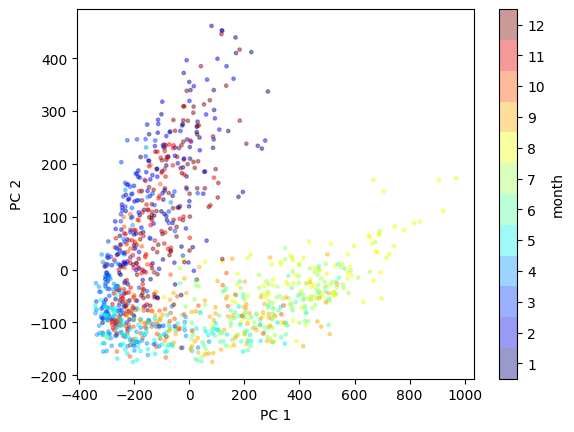

In [245]:
month_of_year = pivoted_load_data.index.month
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.clim(0.5, 12.5);

mid-year cluster 0:  summer months : 
    - demand: colling during the mid-day period
    - typically no need for morning cooling
January/December are cluster 1: winter months
    - demand: warming in the morning | warming in the evenings


So without any initial assumption, we have noticed two major daily patterns and then discovered how those represent summer and winter electricity usage patterns

/tmp/ipykernel_26600/3173301239.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 7), alpha=0.4)


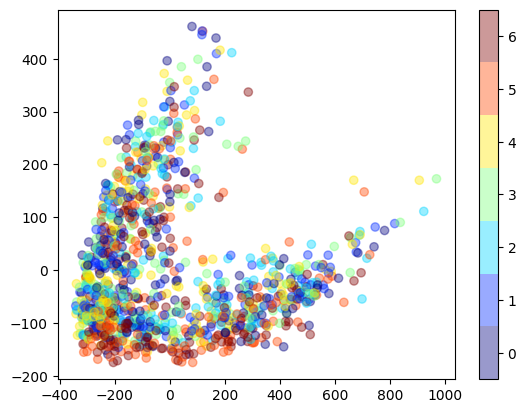

In [236]:
day_of_week = pivoted_load_data.index.day_of_week
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=day_of_week,
            cmap=plt.cm.get_cmap('jet', 7), alpha=0.4)
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

mid-year cluster 0:  summer months : 
    - demand: colling during the mid-day period
    - typically no need for morning cooling
January/December are cluster 1: winter months
    - demand: warming in the morning | warming in the evenings


So without any initial assumption, we have noticed two major daily patterns and then discovered how those represent summer and winter electricity usage patterns when we overlay the months on the principal co-efficients. While there are some similarities in both seasons, there are notable differences. In the summer months there is a simgle peak which occurs in the evening around 6 pm while here are two peaks in the winter months; one in the morning aroun 8am and the other around 8pm.

TO understand this summer winter patterns,, it may be worth considering the nature of electricity use in those tmes. In the summer months, there is often ned for cooling which in the relatively warmer afternoons, which explains the rise from morning till the early evening where the need for cooling is reduced. In the winter months however, heating would be needed in the mornings and evenings when it is cool and least required in the afternoon where the temperature is typically highest.

THis analysis also underscore the strong influence of temperature/weather on energy usage. North Carolina is located well North of the eqautor with significiant temperature swings.  It is possible to imaging that areas closer to the equator where temperatures are more stable year round do not hvae as strong correlation with temperature.

## Demand by Time

### Month

<Axes: xlabel='month', ylabel='load'>

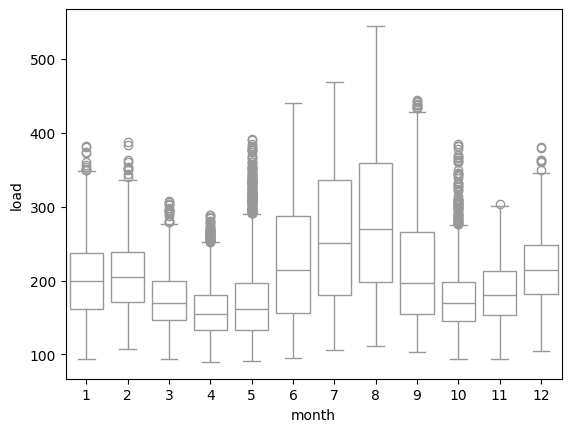

In [249]:
temp_df = (raw_load_data.copy()
           .assign(month = raw_load_data.datetime.dt.month)
           )

sns.boxplot(x='month', y='load', data=temp_df, color='w')

### Day of the week

<Axes: xlabel='day_of_wk', ylabel='load'>

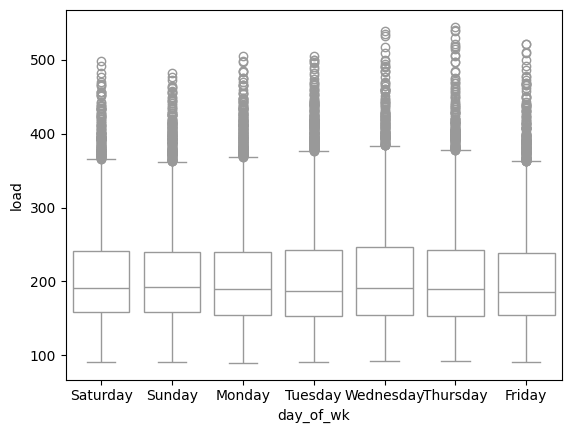

In [250]:
temp_df = (raw_load_data.copy()
           .assign(day_of_wk = raw_load_data.datetime.dt.day_name())
           )


sns.boxplot(x='day_of_wk', y='load', data=temp_df, color='w')

### hour of the day

<Axes: xlabel='hr', ylabel='load'>

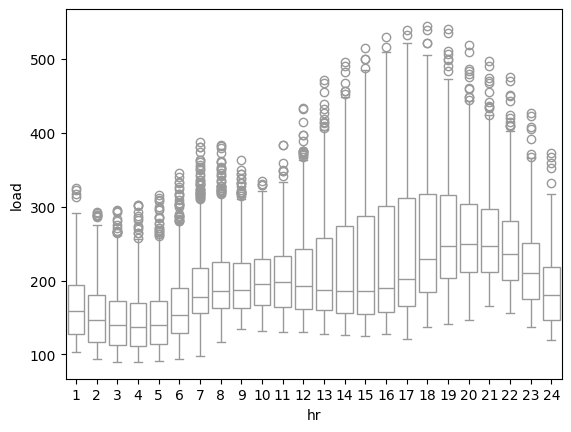

In [251]:
sns.boxplot(x='hr', y='load', data=raw_load_data, color='w');

## weekend hours

<Axes: xlabel='hr', ylabel='load'>

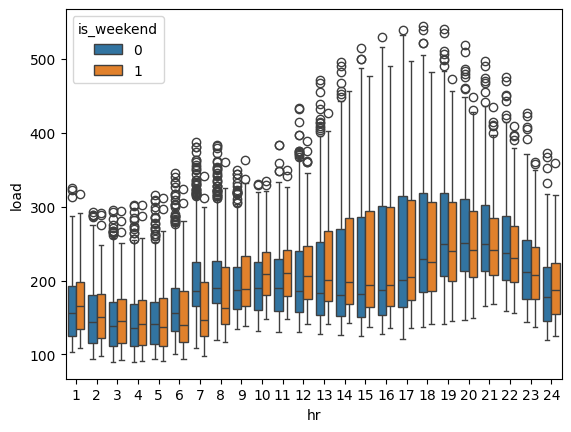

In [254]:
temp_df = (raw_load_data.copy()
           .assign(is_weekend = np.uint8(raw_load_data.datetime.dt.day_of_week > 4))
        #    .query('is_weekend==1')
        )


sns.boxplot(x='hr', y='load', data=temp_df, hue='is_weekend')

Weekends tends to be times when we wake up late and stay home for much longer in the day. From the graph, usage is lower between 6 and 8 am during the weekend which may be attributed to waking relatively later than in weekedays. however, as time passes into the day this reverses with increase usages in the weekend which may be due to families being awake and at home

We have seen that electricity demand is heavily dependent on time including time of day,  month, through waht looks like a combination of the daily activity pattern and climate/weather needs. 

Not much variation in overall demand for different days of the work week. There are some slight variations in usage patterns between weekend and weekdays that follow from intuition. 

## Temperature Data

In [268]:
raw_temp_data.head()

raw_temp_data = raw_temp_data[raw_temp_data.date < '2008']
raw_temp_data['datetime'] = raw_temp_data.date + pd.to_timedelta(raw_temp_data.hr, unit='h')  
print(raw_temp_data.head(3)), 
print(raw_temp_data.shape)

        date  hr  station_id  temperature            datetime
0 2005-01-01   1           1           43 2005-01-01 01:00:00
1 2005-01-01   2           1           41 2005-01-01 02:00:00
2 2005-01-01   3           1           40 2005-01-01 03:00:00
(735840, 5)


In [269]:
print(raw_load_data.shape[0])

26280


In [270]:
n_of_unique_stations = raw_temp_data.station_id.nunique()

n_temp_hours = raw_temp_data.shape[0] / n_of_unique_stations
print(n_temp_hours)
print(f"There are {n_of_unique_stations} unique stations")

26280.0
There are 28 unique stations


In [272]:
print(raw_temp_data.date.value_counts() / n_of_unique_stations)

date
2007-11-04    25.0
2005-10-30    25.0
2006-10-29    25.0
2005-01-01    24.0
2006-12-30    24.0
              ... 
2006-01-10    24.0
2007-12-31    24.0
2007-03-11    23.0
2006-04-02    23.0
2005-04-03    23.0
Name: count, Length: 1095, dtype: float64


m, similarly there is the daylight svaing time problem.

### preprocessing

In [284]:
temp_data = (raw_temp_data.copy()
             .query("date < '2008'")
             .assign(dummy_col=np.arange(len(raw_temp_data)) % 2)  # to preserve the repeated hours during pivot
             .pivot_table( values='temperature', index=['date', 'hr','datetime', 'dummy_col'], columns='station_id')
             )
#print(temp_data.head(2))

temp_data = (temp_data
             .reset_index()
             .drop(labels=['dummy_col', 'date', 'hr'], axis=1)
             .pipe(lambda d: d.rename(columns=dict([( col, 't'+str(col)) for col in d.columns if isinstance(col, int)])))
             )
temp_data_pivot = temp_data.copy()
print(temp_data_pivot.head(2))

station_id            datetime    t1    t2    t3    t4    t5    t6    t7  \
0          2005-01-01 01:00:00  43.0  46.0  40.0  47.0  48.0  46.0  44.0   
1          2005-01-01 02:00:00  41.0  46.0  38.0  46.0  48.0  45.0  51.0   

station_id    t8    t9  ...   t19   t20   t21   t22   t23   t24   t25   t26  \
0           52.0  45.0  ...  39.0  50.0  43.0  45.0  50.0  47.0  41.0  47.0   
1           50.0  42.0  ...  41.0  49.0  43.0  46.0  47.0  47.0  45.0  47.0   

station_id   t27   t28  
0           47.0  45.0  
1           47.0  45.0  

[2 rows x 29 columns]


In [313]:
temp_data_pivot.columns

Index(['datetime', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10',
       't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20',
       't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28'],
      dtype='object', name='station_id')

### Exploratory Analysis

Text(0, 0.5, 'Temperature, $^\\circ$F')

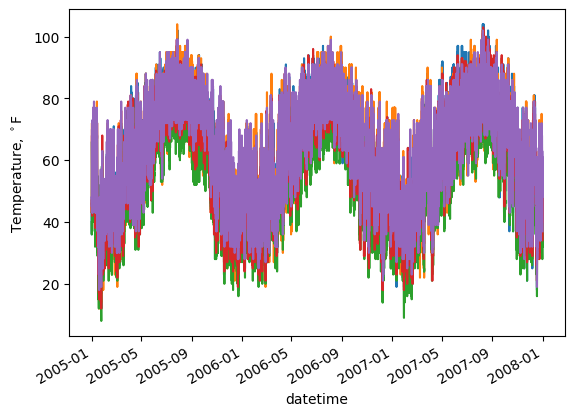

In [287]:
fig, ax = plt.subplots()
temp_data_pivot.set_index('datetime').iloc[:, :5].plot(legend=False, ax=ax)

ax.set_ylabel("Temperature, $^\circ$F")

We see the periodic annual pattern which was already implied by the preiovious analysis

#### Load and Temp

/tmp/ipykernel_26600/1840998436.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


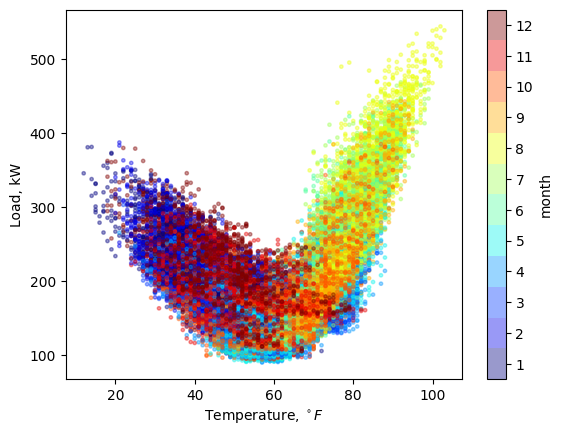

In [311]:
temp_df = (raw_load_data.copy()
           .assign(temp = temp_data_pivot.iloc[:, 4])
           .assign(month = raw_load_data.datetime.dt.month)
           )

# sns.scatterplot(x='temp', y='load', data=temp_df, alpha=0.2, size=0.2, hue='month')

month_of_year = raw_load_data.datetime.dt.month
plt.scatter(x=temp_df.temp, y=raw_load_data.load, c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Temperature, $^\circ F$')
plt.ylabel('Load, kW')
plt.clim(0.5, 12.5);

The plot follows some of our preveious finding on the Temperature and load demand. Particularly notable heaere is that cooling demand during high tempretaures in August is largely responsible for the peak loads

#### Temperature Lags

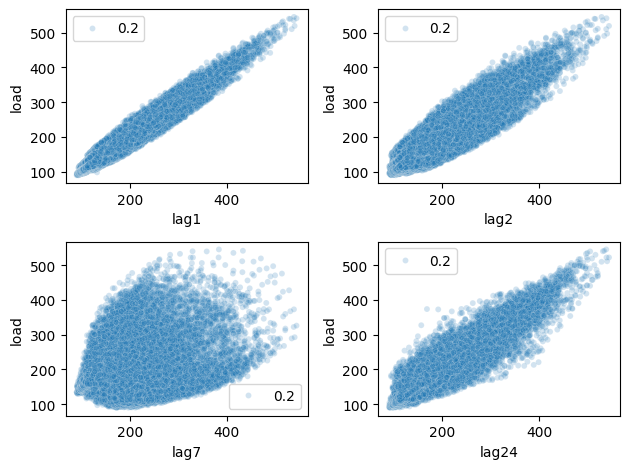

In [312]:
temp_df = (
    raw_load_data.copy()
    .assign(lag1=raw_load_data.load.shift(1))
    .assign(lag2=raw_load_data.load.shift(2))
    .assign(lag7=raw_load_data.load.shift(7))
    .assign(lag24=raw_load_data.load.shift(24))
)
fig, axs = plt.subplots(2, 2)
sns.scatterplot(x="lag1", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 0])
sns.scatterplot(x="lag2", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 1])
sns.scatterplot(x="lag7", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 0])
sns.scatterplot(
    x="lag24", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 1]
)
# set_plot_labels(axs, xlabel="temp")
fig.tight_layout()

### subset temp columns
We have to determine a strategy for selecting the optimal temperature stations considering there are quite a number of them

features:
- historical load and temp dataframe
- inference input:
    - date
    - temperature (28 stations)
- engineering:
    - trend
    - date comp:
        - h, d, m, is_holiday, season_func
    - lags:
        - temp 1, 2
        - load 1, 2
    - temp
        - one at a time and get score
            - 1,2,3 order,
            - interaction: TM, Mt2, Mt3, HT, Ht2, Ht3
        - get subset
-       - 

        


# Feature Engineering

In [158]:
from src.modelling import training
from sklearn.mixture import GaussianMixture as GM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from src import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
project_root = utils.get_proj_root()
config = utils.get_config('config/config.ini')

In [159]:
preprocessed_data = training.get_training_data()
load_data  = preprocessed_data[['datetime','load']].copy()
load_data['hour'] = preprocessed_data['datetime'].dt.hour.values
load_data['date'] = preprocessed_data['datetime'].dt.date.values
# print(load_data.head())

load_data_pivoted = load_data.pivot_table(values='load', index='date', columns='hour')
print(load_data_pivoted.isnull().sum())
X = load_data_pivoted.loc[:, 3:].values  # from 3 because some hours are null for hour 2

n_components=2
X_pca = PCA(n_components=n_components).fit_transform(X)


gmm = GM(n_components=n_components, covariance_type='full', random_state=0)

gmm.fit(X_pca)
cluster_label = gmm.predict(X_pca)

print(len(load_data_pivoted), len(cluster_label))
load_data_pivoted['cluster'] = cluster_label
# print(load_data_pivoted.head())
temp_df = load_data.join(load_data_pivoted['cluster'], on='date')
# print(temp_df.head())
temp_df = temp_df.groupby(['cluster', temp_df.datetime.dt.time]).median(numeric_only=True)


def normalize(x:np.array):

    res = (x - x.mean()) / x.std()
    return res

cluster_0_profile = temp_df.loc[0]['load'].values 
cluster_1_profile = temp_df.loc[1]['load'].values
# print(temp_df)
# plt.plot(cluster_1_profile)

daily_load_profile_feature = {
    'profile_1':dict(zip(temp_df.loc[0]['hour'].values.astype(int), normalize(temp_df.loc[0]['load'].values))),
    'profile_2':dict(zip(temp_df.loc[1]['hour'].values.astype(int), normalize(temp_df.loc[1]['load'].values)))
}

print(daily_load_profile_feature)

file_path = project_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
utils.save_value(daily_load_profile_feature, fname=file_path)


hour
0     1
1     0
2     3
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64
1095 1095
{'profile_1': {0: -0.41817854851221764, 1: -0.8545522797240364, 2: -1.1166763666878774, 3: -1.2755959321651045, 4: -1.3761463915561651, 5: -1.4081707235081036, 6: -1.2812822433214797, 7: -0.9939749564738815, 8: -0.9002926425056641, 9: -0.7461206741103036, 10: -0.4602991217691219, 11: -0.1346868980106436, 12: 0.21276562299215598, 13: 0.5452662521894741, 14: 0.8415824928168876, 15: 1.080245481256681, 16: 1.2693051971981641, 17: 1.39214167418547, 18: 1.4495045328104732, 19: 1.3382635383118804, 20: 1.0681705117227152, 21: 0.9006674528016005, 22: 0.688180405029398, 23: 0.1798836170296953}, 'profile_2': {0: -0.6096543733192551, 1: -1.2306586276551332, 2: -1.468022347257488, 3: -1.5223486889028761, 4: -1.460485744948302, 5: -1.1673433176305594, 6: -0.374979493603251, 7: 0.8763

In [160]:
preprocessed_data['datetime'].dt.hour.map(daily_load_profile_feature['profile_1'])

0       -0.854552
1       -1.116676
2       -1.275596
3       -1.376146
4       -1.408171
           ...   
26274    1.338264
26275    1.068171
26276    0.900667
26277    0.688180
26278    0.179884
Name: datetime, Length: 26279, dtype: float64

In [179]:
from src.modelling import transforms
daily_load_profile_path = project_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
df = transforms.HourlyProfileTransformer(datetime_column_name='datetime', feature_path=daily_load_profile_path).fit_transform(preprocessed_data)

df = transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour).fit_transform(df)
                                                            

In [180]:
categorical_column_names = ['hour', 'month']
columns_to_drop = ['date', 'mean_temp']

temperature_column_names_path = project_root.joinpath(config['modelling_paths']['temperature_columns'])
optimal_temperature_column_names_path = project_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
daily_load_profile_path = project_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])


pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.median, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),

                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_non_linear_hour_features",transforms.HourlyProfileTransformer(datetime_column_name='datetime',
                                                         feature_path=daily_load_profile_path)),                         
                
                # ("create_interaction_temp_hour_profile_1",transforms.MultiColumnTransformer(column_names=['mean_temp', 'profile_1'], 
                #                                             new_column_name='temp_hour_p1', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                ("create_interaction_temp_hour_profile_2",transforms.MultiColumnTransformer(column_names=['mean_temp', 'hour'], 
                                                            new_column_name='temp_hour_p2', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("create_interaction_temp_month",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month'], 
                                                            new_column_name='temp_month', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("create_interaction_month_hour_profile_1",transforms.MultiColumnTransformer(column_names=['month', 'profile_1'], 
                                                            new_column_name='month_hour', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("create_interaction_month_hour_profile_2",transforms.MultiColumnTransformer(column_names=['month', 'hour'], 
                                                            new_column_name='month_hour_p2', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),                                    
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )

df = pipeline.fit_transform(df)
  

<Axes: xlabel='hour', ylabel='load'>

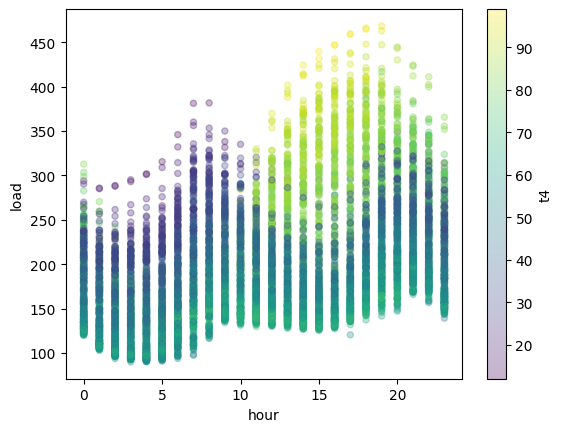

In [194]:
df[:10000].plot.scatter(x='hour', y='load', c='t4', alpha=0.3)

# plt.scatter(x=df.hour, y='load', color='month')
# print(df[:1000].datetime.max())

<Axes: >

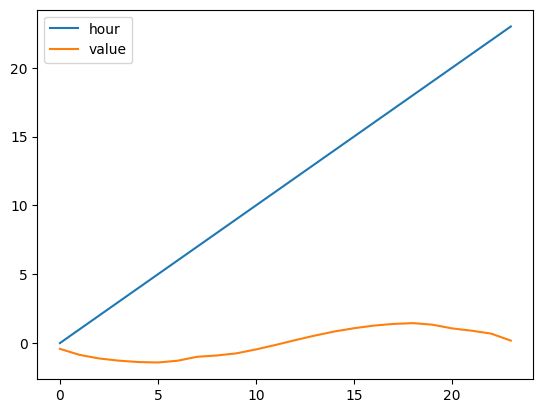

In [138]:
a = utils.load_value(daily_load_profile_path)

import pandas as pd
p_1 = a['profile_1']
df = pd.DataFrame({'hour':list(p_1.keys()),
'value':p_1.values()})
df.plot()

In [ ]:
a

In [313]:

## lag features is very problematic:
# - prediction and then training have to be done row by row
# class LagColumnTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, datetime_column_name, value_column_name, n_hours, look_up_data_path) -> None:
#         self.datetime_column_name = datetime_column_name
#         self.value_column_name= value_column_name
#         self.n_hours = n_hours
#         self.look_up_data_path = look_up_data_path
#         self.max_train_datetime = None
#         self.new_column_name= value_column_name+ '_lag_'+str(n_hours)

#     def fit(self, X, y=None):
#         self.max_train_datetime = X[self.datetime_column_name].max()
#         return self

#     def transform(self, X: pd.DataFrame):

#         datetimes_to_look_up = X[self.datetime_column_name].values
        
#         if datetimes_to_look_up.max() <= self.max_train_datetime:
#             # get lag from input data
#             values = X[self.value_column_name].shift(self.n_hours).fillna(method='backfill')
#         else:
#             # TODO: do something different here
#             values = X[self.value_column_name].shift(self.n_hours).fillna(method='backfill')

#         X[self.new_column_name] = values

        
#         logging.getLogger(self.__class__.__name__).info(f"created: {self.new_column_name}")
#         return X
    


    # def nearest_date(date, ref_dates):
    #     return min(ref_dates, key=lambda x: abs(x - date))

    # def get_value_at_date(dates:pd.Series, look_up_data:pd.DataFrame, date_column, look_up_column):
    #     values = []
    #     for date in dates:
    #         value    = look_up_data[look_up_data[date_column]==date][look_up_column].values[0]
    #         values.append(value)
    #     return values

    # def get_closest_value_by_date(dates:pd.Series, look_up_data:pd.DataFrame, date_column,  look_up_column):

    #     if set(datetimes_to_look_up.values).issubset(look_up_data[date_column].values):
    #         return get_value_at_date(dates, look_up_data, date_column, look_up_column)
    #     else:
    #         approx_dates = []
    #         for date in dates:
    #             value = nearest_date(date, look_up_data[date_column].values)
    #             approx_dates.append(value)

    #         return get_value_at_date(approx_dates, look_up_data, date_column, look_up_column)

# def get_training_data(file_path: pathlib.Path = None):
#     """Reaturns the combined load and temperature data, for the training dates"""
#     df = pd.read_csv(file_path)
#     df['datetime'] = pd.to_datetime(df['datetime'].values)
#     # print(df.head(2))
#     df = df[df.datetime.dt.year < 2008]

#     return df

## Evaluation

In [239]:
from src.preprocessing import preprocessing as prep
from src.inference import inference as inf
from src import utils

proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

model_name = 'xgboost'
model = inf.load_model(model_name=model_name)

raw_temperature_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])
raw_temperature_data = pd.read_csv(raw_temperature_data_path, parse_dates=[0])
preprocessed_temperature_data = prep.TempDataPreprocessor().fit(raw_temperature_data).transform(raw_temperature_data)
inf_year = 2008
preprocessed_temperature_data = preprocessed_temperature_data[preprocessed_temperature_data.datetime.dt.year >= inf_year]
preprocessed_temperature_data = preprocessed_temperature_data.iloc[1:, :]  # includes first date not in eval
future_dates = preprocessed_temperature_data.datetime #+ p.to_timedelta(preprocessed_temperature_data.datetime.dt.hour, unit='h')

predicted_load = model.predict(preprocessed_temperature_data)

eval_data_path = config['data_paths']['evaluation_data']
actual_load = pd.read_csv(proj_root.joinpath(eval_data_path), parse_dates=[0])
actual_load = prep.LoadDataPreprocessor().fit(actual_load).transform(actual_load)


fiitng
transform


<Axes: xlabel='datetime'>

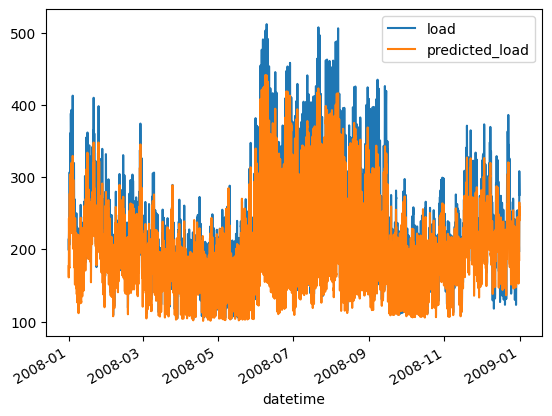

In [240]:
prediction_data = pd.DataFrame({'datetime':future_dates, 'predicted_load':predicted_load})
# prediction_data.set_index('datetime', inplace=True)
n_pts = 20000
fig, ax = plt.subplots()
actual_load[:n_pts].plot(x='datetime', y='load', ax=ax)
prediction_data[:n_pts].plot(x='datetime', y='predicted_load', ax=ax)